**Oreum Industries Internal Project, 2024Q3**

---

# 302_Piecewise_CoxPH3.ipynb

### Survival Regression Demo in `oreum_survival`

Demonstrate Survival Regression Modelling using Bayesian inference and a 
Bayesian workflow, specifically using the `pymc` & `arviz` ecosystem.

**In this Notebook:**

+ We extend our basic understanding with worked examples of semi-parametric models in the CoxPH
  architecture family, using our real-world observational censored dataset.
+ Specifically **Extending CoxPH: Ordinal Hierarchical Baseline Hazard & Coeffs**

## Contents

+ [Setup](#Setup)

+ [0. Load Dataset](#0.-Load-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `CoxPH3`](#2.-Custom-Bayesian-Model-`CoxPH3`)

# Setup

## Imports

In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from oreum_core import curate, eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))


from engine import logger, utils
from model import exponential, piecewise

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip
import seaborn as sns

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

log = logger.get_logger('302_Piecewise_CoxPH3', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RNG = np.random.default_rng(seed=42)
STEP = 14

## Data Connections and Helper Objects

In [4]:
csvio = curate.PandasCSVIO(here(Path('data', 'raw', 'verbatim')).resolve(strict=True))
ppqio = curate.PandasParquetIO(here(Path('data', 'prepared')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))

---

---

# 0. Load Dataset

In [5]:
dfr = csvio.read(fn='mastectomy', index_col='rowid')
eda.display_ht(dfr)

,time,event,metastized
rowid,,,
0,23,True,no
1,47,True,no
2,69,True,no
41,212,False,yes
42,217,False,yes
43,225,False,yes


'Shape: (44, 3), Memsize 0.0 MB'

##### Correct dtypes etc

In [6]:
df = dfr.copy()
df['pid'] = ['p{}'.format(x) for x in range(len(df))]
df = df.reset_index(drop=True).set_index('pid')
df.rename(columns={'time': 'duration', 'event': 'death', 'metastized': 'met'}, inplace=True)
df['death'] = df['death'].astype(bool)
df['met'] = df['met'].apply(lambda x: True if str(x).strip() == 'yes' else False)
eda.describe(df)

,28,3,33,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p28,p3,p33,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,68,70,109,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death,True,False,False,bool,0,NaN,NaN,2,True,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
met,True,False,True,bool,0,NaN,NaN,2,True,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'Shape: (44, 4), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 Extending CoxPH: Ordinal Hierarchical Baseline Hazard & Coeff

In `302_Piecewise_CoxPH2.ipynb` we demonstrated an improved model `CoxPH2` which has a partially-pooled (hierarchial) **strictly ordinal time-dependent 
baseline hazard** $\lambda_{0}$ and unpooled static covariates $\beta$

**Here:** 

We create a more sophisticated model `CoxPH3` which has a partially-pooled (hierarchial), strictly ordinal time-dependent 
baseline hazard $\lambda_{0}$ and **partially-pooled (hierarchial), strictly ordinal time-dependent coefficients $\beta$**
+ The partial-pooling constrains both parameters $\lambda_{0}$ and $\beta$ toward a group mean, encouraging a more robust fit, and the ordinal sequencing is achieved using a `GaussianRandomWalk` which further constrains movements to be proximate.
+ Note the priors are very sensitive, especially on the very small dataset that we're using

---

---

# 2. Custom Bayesian Model `CoxPH3`

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use this transformed dataset `dfx` 
in all subsequent models where possible

NOTE:

+ For this example Notebook we will _not_ partition into train & holdout sets
  (see `README.md ## 5. Data Standards` for terminology)
+ Instead we will simply fit the entire dataset and evaluate in-sample using
  Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ This means we still follow our standard process for preparation, 
  transformation, standardization, but abbreviate to `dfa` only


In-house preferred process (transformation, standardization) to create `dfx` for model usage 

In [7]:
dfx_creator = utils.ProjectDFXCreator()
dfx = dfx_creator.get_dfx(df)
eda.describe(dfx)

,3,30,36,dtype,count_null,count_inf,count_zero,count_unique,top,freq,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,,,,
index: pid,p3,p30,p36,object,0,NaN,NaN,44,p0,1,NaN,NaN,NaN,p0,NaN,NaN,NaN,p9
duration,70,76,118,int64,0,0.0,0.0,NaN,NaN,NaN,4251.0,96.61,69.87,5.0,38.75,73.5,145.75,225.0
death_t_true,0,0,1,int64,0,0.0,18.0,NaN,NaN,NaN,26.0,0.59,0.5,0.0,0.0,1.0,1.0,1.0
intercept,1.0,1.0,1.0,float64,0,0.0,0.0,NaN,NaN,NaN,44.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
met_t_true,0,1,1,int64,0,0.0,12.0,NaN,NaN,NaN,32.0,0.73,0.45,0.0,0.0,1.0,1.0,1.0


'Shape: (44, 5), Memsize 0.0 MB'

## 2.1 Build Model Object

`CoxPH3` model imported from `src.models.piecewise.py` where it is fully defined

In [8]:
mdl_cox3 = piecewise.CoxPH3(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox3.build()
utils.display_rvs(mdl_cox3)
mdl_cox3.debug()

'RVs for coxph3, v1.1.0, dfx'

lambda_j_mu ~ Normal(-5, 1)

lambda_j_mu_offset ~ RandomWalk(Normal(0, 1), Normal(0, 1), f())

lambda_j_sigma ~ InverseGamma(101, 100)

beta_mu ~ Normal(-3, 1)

beta_mu_offset ~ RandomWalk(Normal(0, 1), Normal(0, 1), f())

beta_sigma ~ InverseGamma(101, 100)

lambda_j ~ Deterministic(f(lambda_j_mu_offset, lambda_j_mu, lambda_j_sigma))

beta ~ Deterministic(f(beta_mu, beta_sigma, beta_mu_offset))

shat_ij ~ Deterministic(f(lambda_j_mu_offset, lambda_j_mu, lambda_j_sigma, beta_mu, beta_sigma, beta_mu_offset))

point={'lambda_j_mu': array(-5.), 'lambda_j_mu_offset': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'lambda_j_sigma_log__': array(0.), 'beta_mu': array([-3.]), 'beta_mu_offset': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), 'beta_sigma_log__': array([0.])}

No problems found
point={'lambda_j_mu': array(-5.), 'lambda_j_mu_offset': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'lambda_j_sigma_log__': array(0.), 'beta_mu': array([-3.]), 'beta_mu_offset': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]]), 'beta_sigma_log__': array([0.])}

No problems found


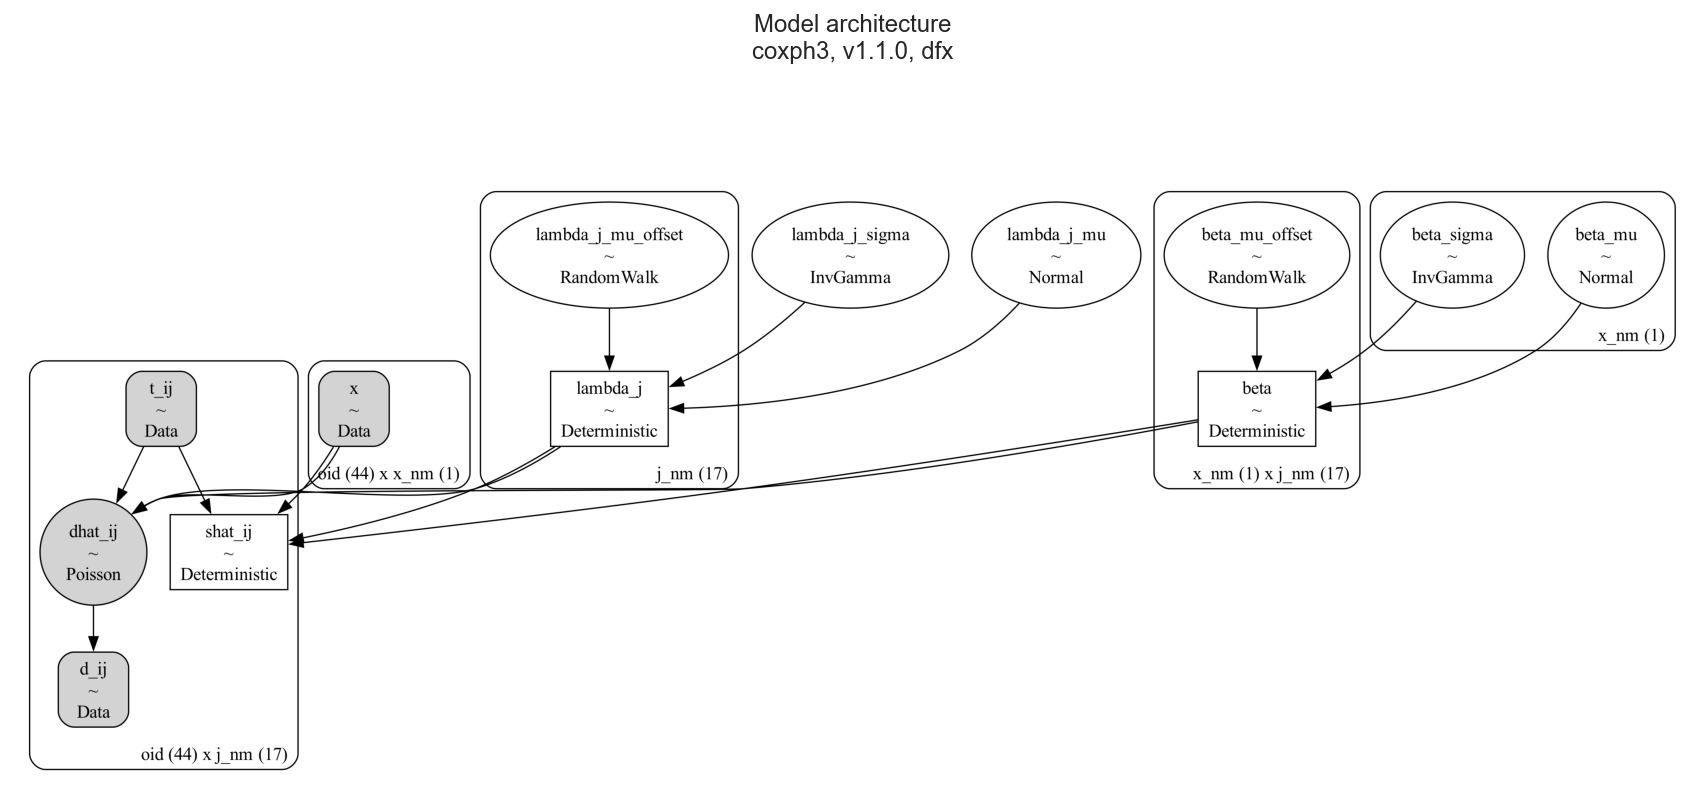

In [9]:
fqn = mdlio.write_graph(mdl_cox3)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdl_cox3.mdl_id}', figsize=(12, 6))

## 2.2 Sample Prior Predictive, View Diagnostics

In [10]:
mdl_cox3.sample_prior_predictive(var_names=mdl_cox3.rvs_lam + mdl_cox3.rvs_b + mdl_cox3.rvs_det + mdl_cox3.rvs_ppc,replace=True)

### 2.2.1 Evaluate PPC vs In-Sample Data

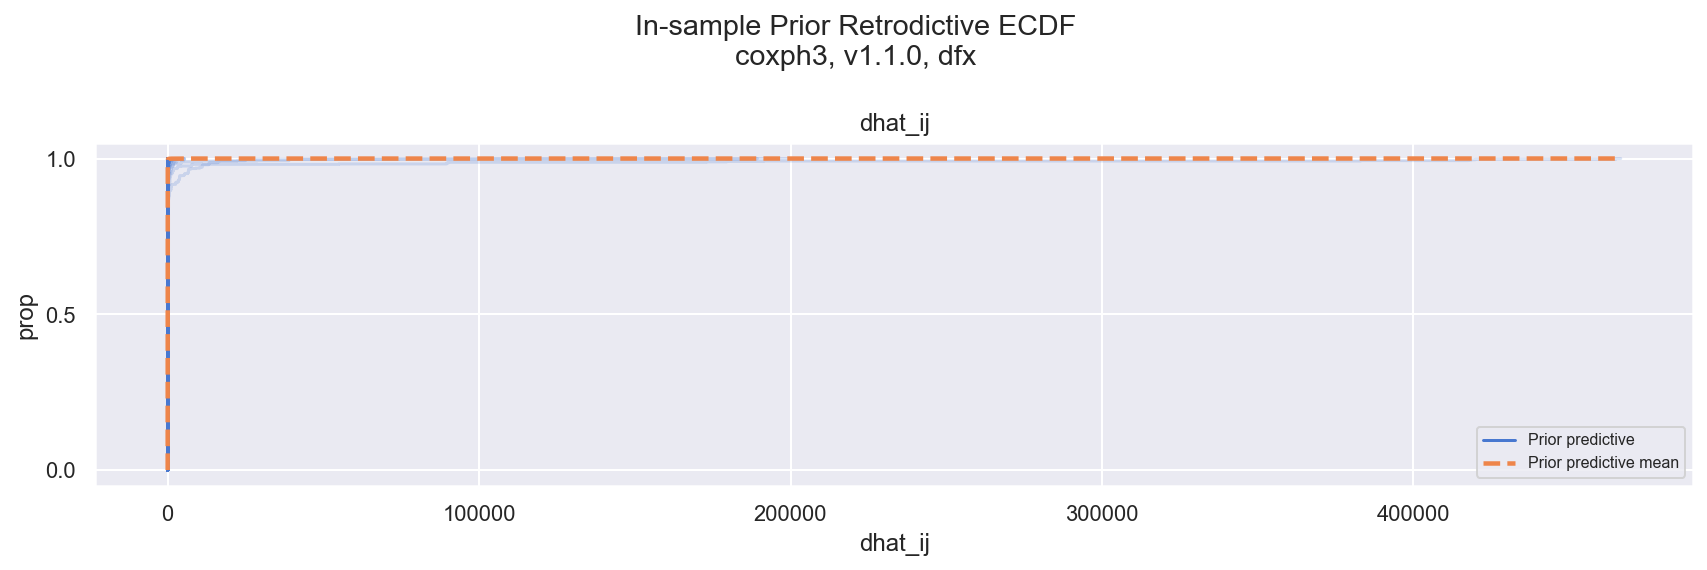

In [11]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdl_cox3, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is technically valid considering it's Poisson

### 2.2.2 Evaluate priors and hyperpriors

#### Hyperpriors on hazard function

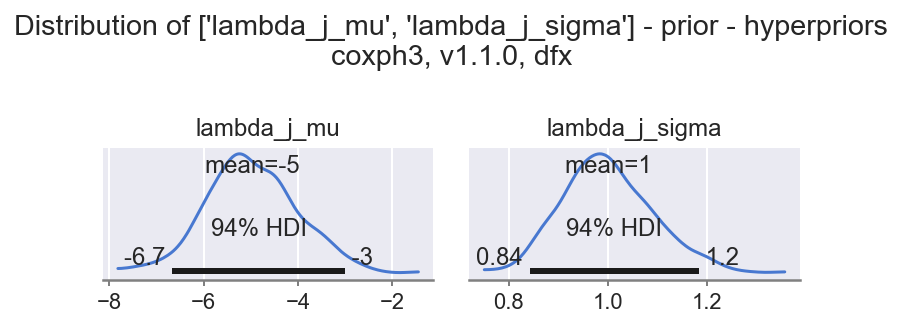

In [12]:
f = mt.facetplot_krushke(mdl=mdl_cox3, group=GRP, txtadd='hyperpriors', rvs=['lambda_j_mu', 'lambda_j_sigma'], m=2)

**Observe**

+ We've set `lambda_j_mu` low to achieve `E(lj) ~ exp(-5) = 0.007`
+ We've set `lambda_j_sigma` to `1` but may need to tighten this up

#### Baseline hazard function $\lambda_{0}$

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/xarray/core/computation.py:818: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


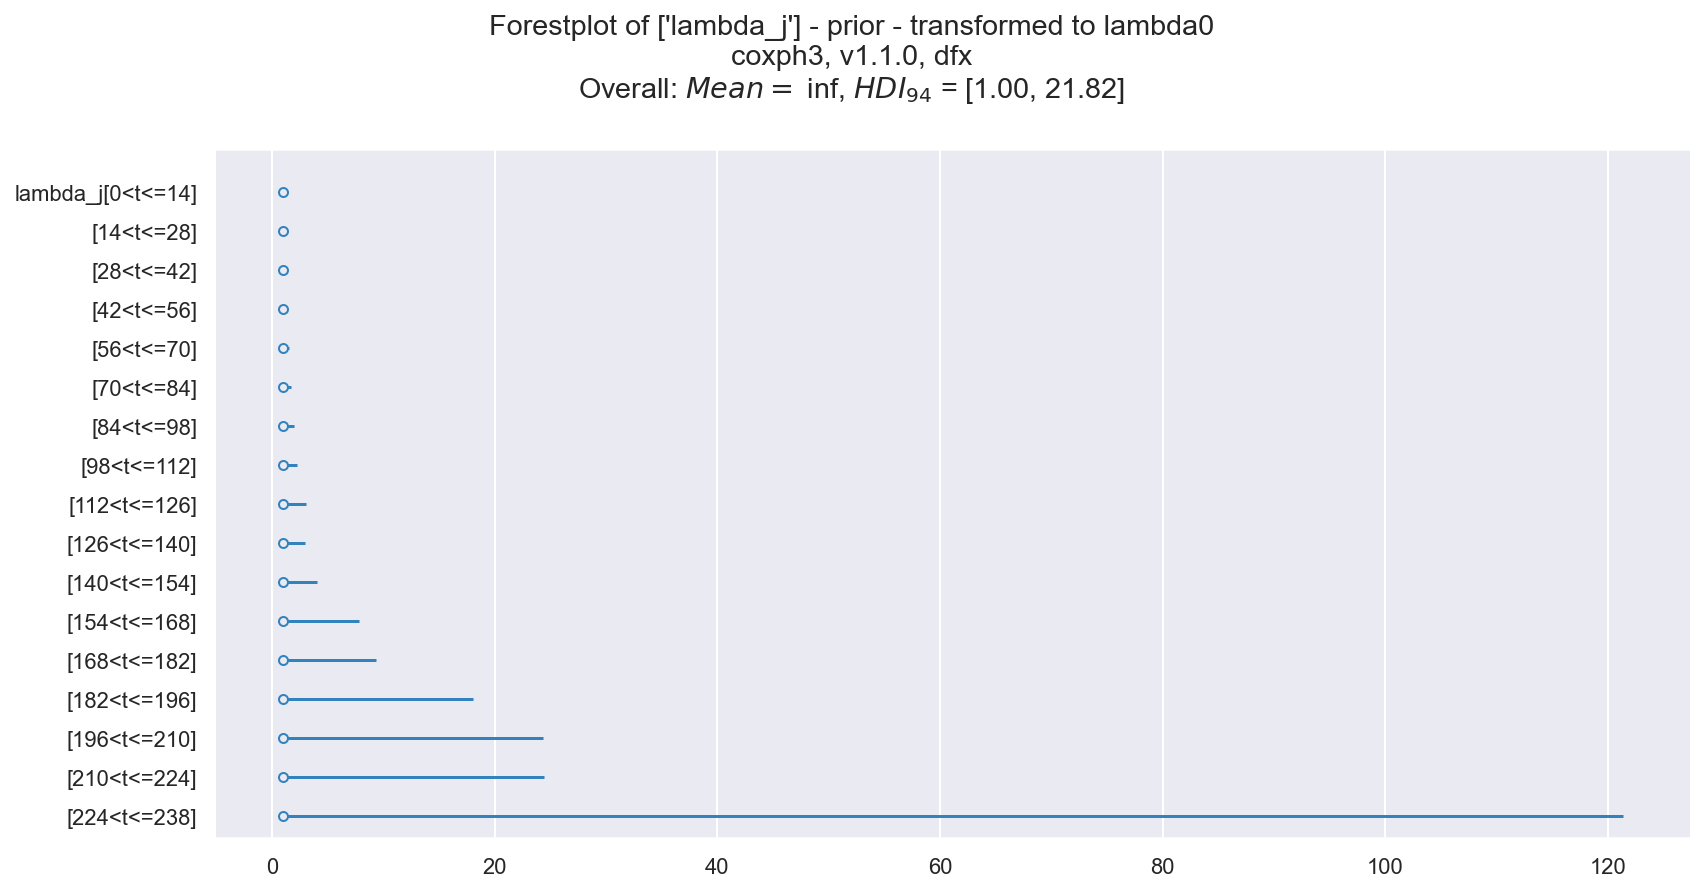

In [13]:
f = mt.forestplot_single(mdl=mdl_cox3, var_names=['lambda_j'], group=GRP, transform=np.exp, txtadd='transformed to lambda0')

**Observe**

+ Priors sitting away from 1, so some effect already - may need to adjust this
+ `HDI94`s nice and wide but very skewed, leading to a high mean
+ For later timesteps $j$ the GaussianRandomWalk has strayed far, possibly too far

#### Hyperpriors on $\beta$

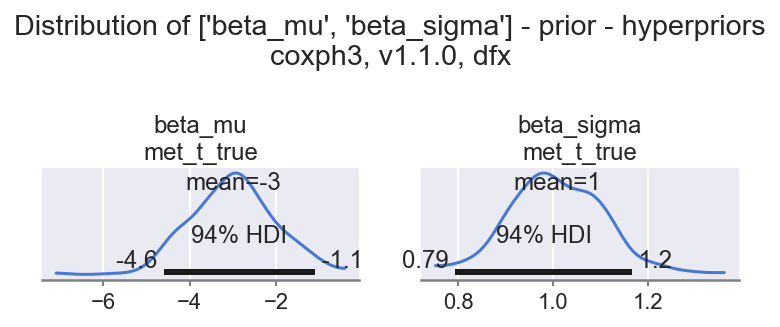

In [14]:
f = mt.facetplot_krushke(mdl=mdl_cox3, group=GRP, txtadd='hyperpriors', rvs=['beta_mu', 'beta_sigma'], m=2)

**Observe**

+ We've set `beta_mu` low to achieve `E(lj) ~ exp(-3) = 0.05`
+ We've set `beta_sigma` to `1` but may need to tighten this up

#### Priors on $\beta$

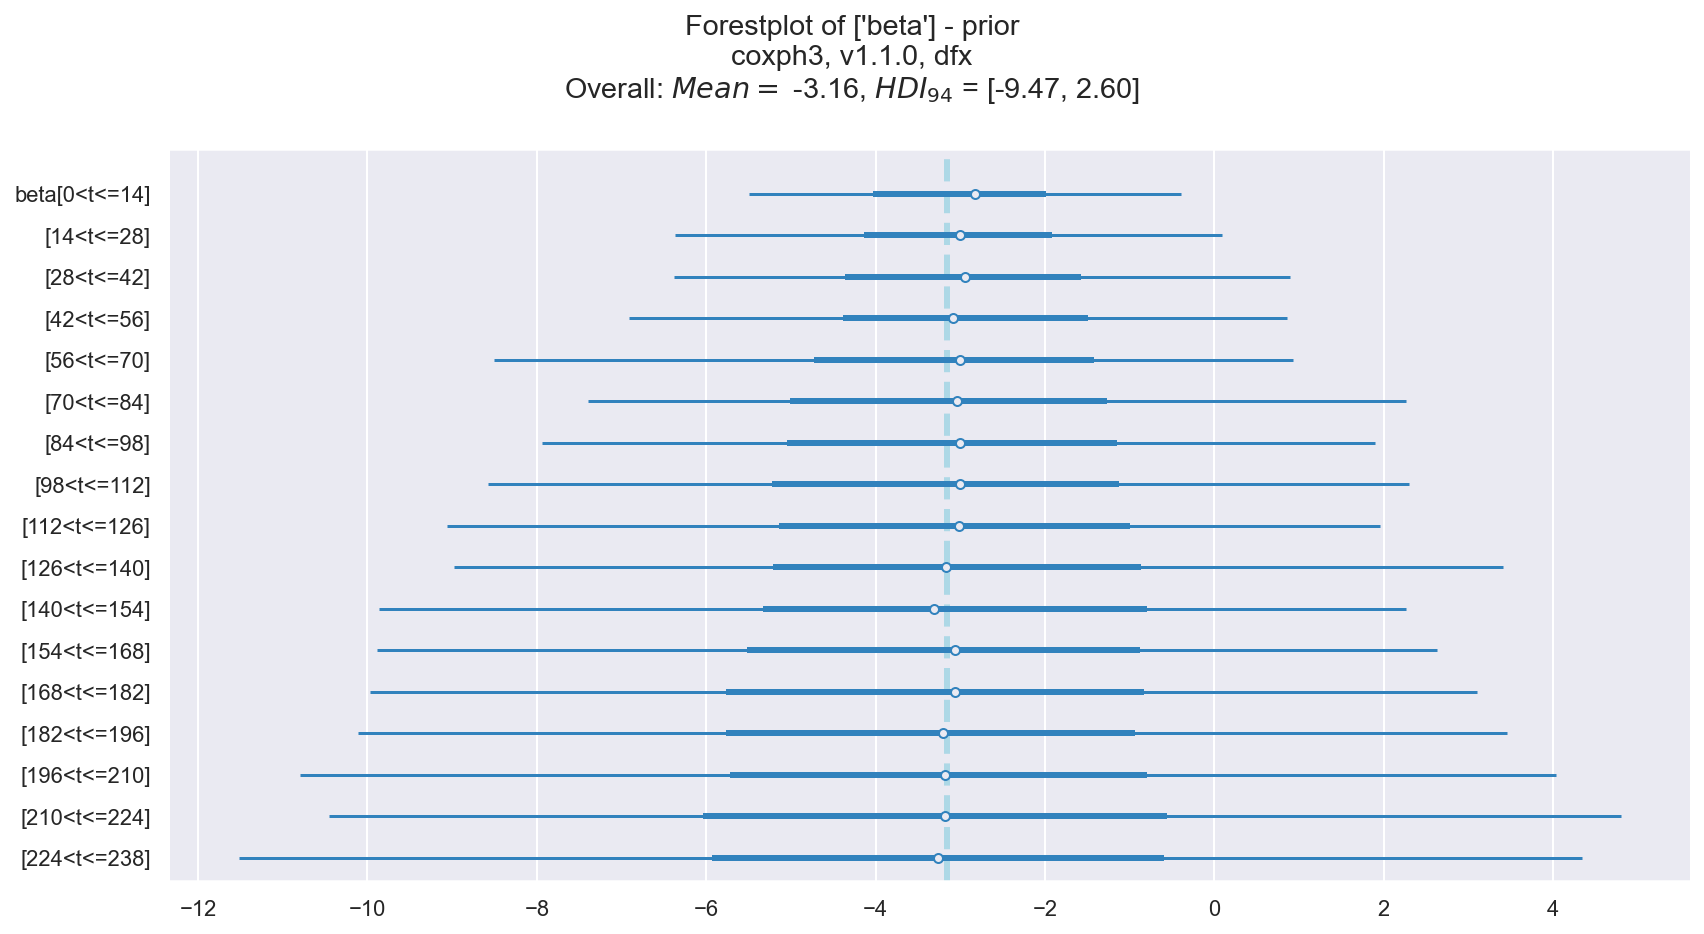

In [15]:
f = mt.forestplot_single(mdl=mdl_cox3, var_names=['beta'], group=GRP)

**Observe**

+ Priors sitting around `beta_mu`, widening due to the GaussianRandomWalk

## 2.3 Sample Posterior, View Diagnostics

In [16]:
mdl_cox3.sample(progressbar=True)
mdl_cox3.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdl_cox3.rvs_ppc)
mdlio.write_idata(mdl=mdl_cox3)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_survival/data/models/idata_coxph3_v110_dfx.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_j_mu,-5.069,0.760,-6.556,-3.707,0.026,0.019,829.0,890.0,1.01
lambda_j_mu_offset[0<t<=14],-0.147,0.764,-1.571,1.330,0.022,0.016,1161.0,1290.0,1.00
lambda_j_mu_offset[14<t<=28],-0.224,0.899,-1.938,1.387,0.028,0.020,1025.0,1210.0,1.01
lambda_j_mu_offset[28<t<=42],-0.460,0.979,-2.444,1.258,0.031,0.022,1009.0,1247.0,1.01
lambda_j_mu_offset[42<t<=56],-0.534,1.025,-2.242,1.701,0.033,0.023,978.0,1188.0,1.00
lambda_j_mu_offset[56<t<=70],-0.509,1.040,-2.467,1.394,0.034,0.024,939.0,1238.0,1.01
lambda_j_mu_offset[70<t<=84],-1.227,1.146,-3.347,1.016,0.037,0.026,954.0,1073.0,1.00
lambda_j_mu_offset[84<t<=98],-1.766,1.226,-4.134,0.380,0.039,0.028,966.0,1188.0,1.00
lambda_j_mu_offset[98<t<=112],-1.691,1.235,-4.231,0.451,0.042,0.030,845.0,1043.0,1.01
lambda_j_mu_offset[112<t<=126],-1.006,1.176,-3.199,1.142,0.041,0.029,818.0,978.0,1.01


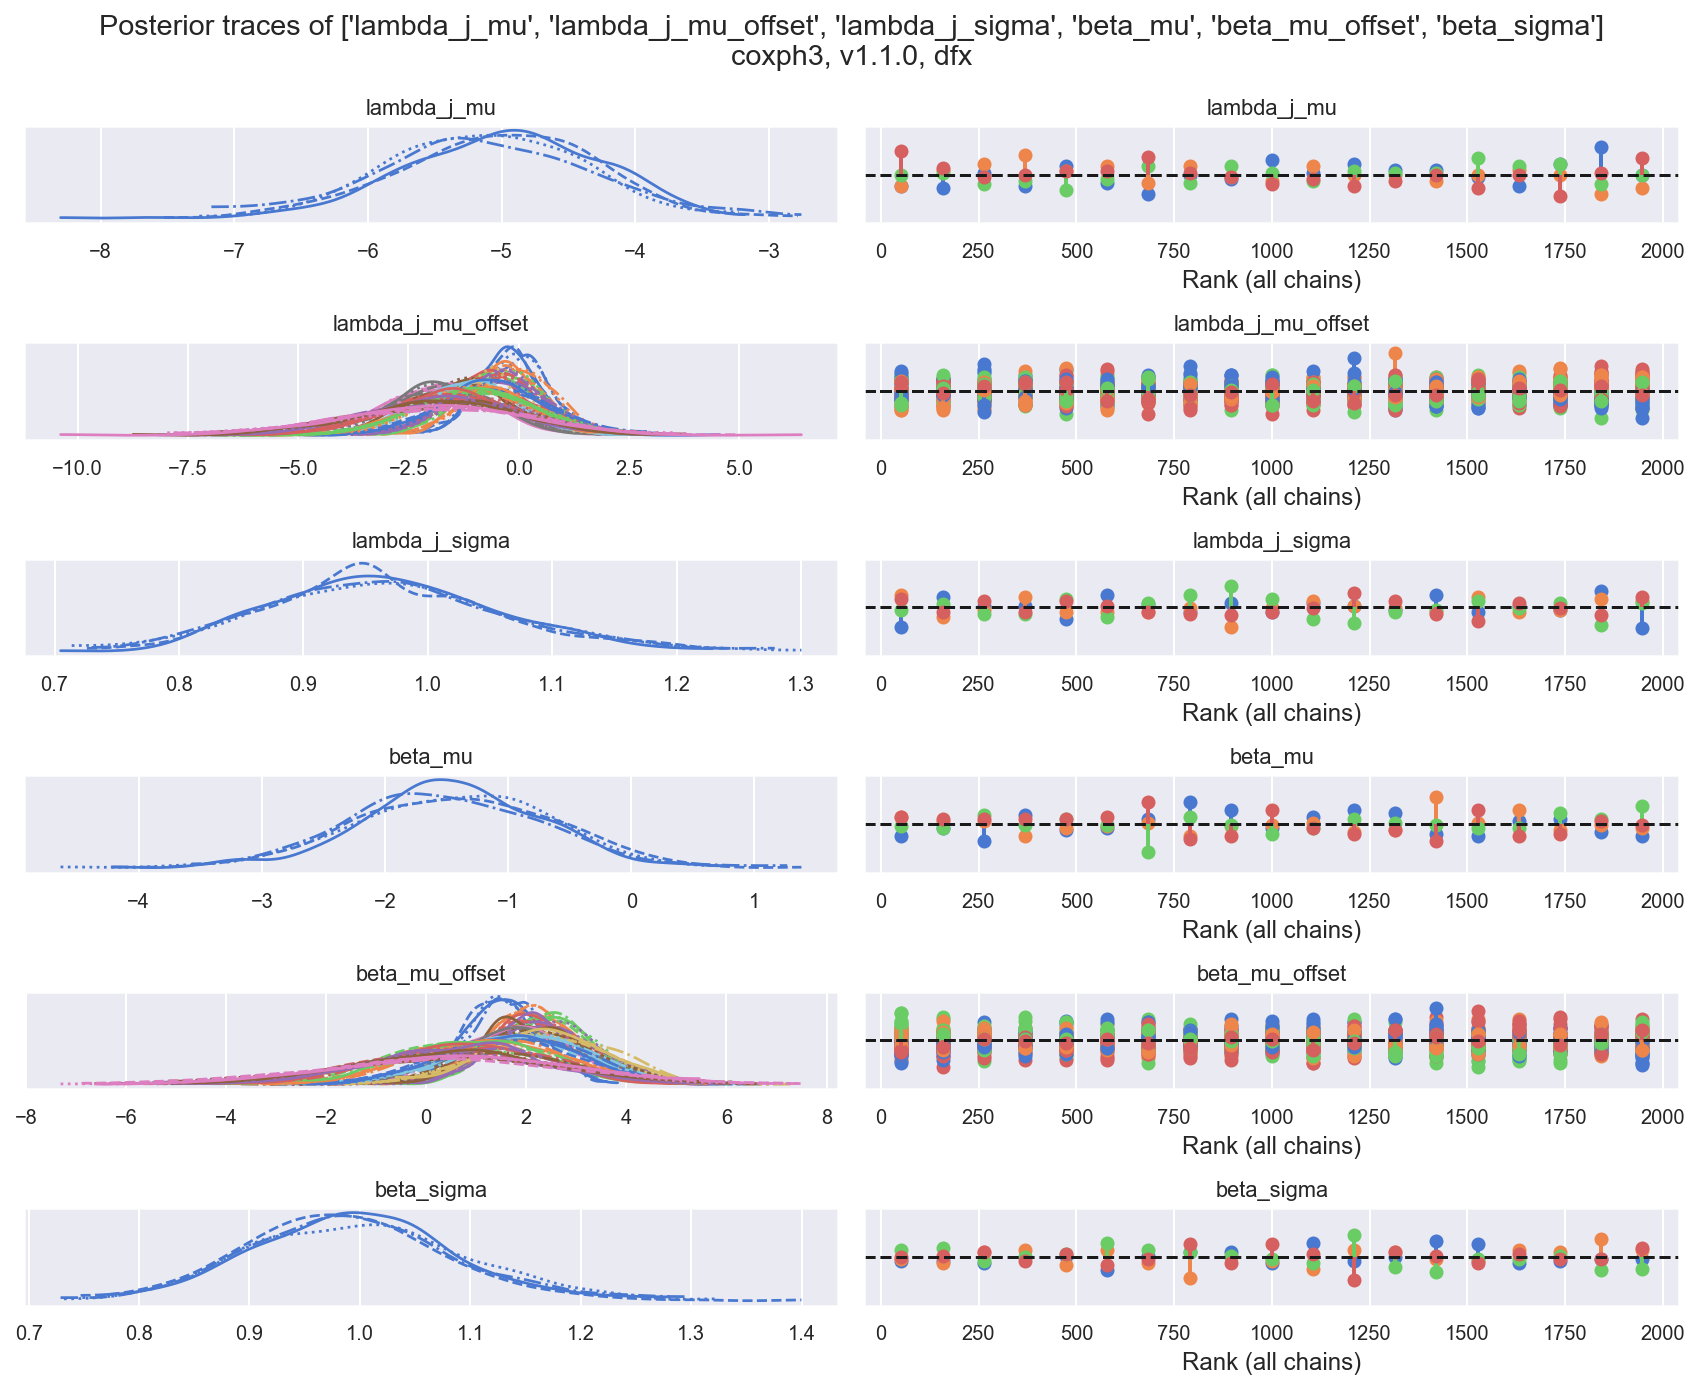

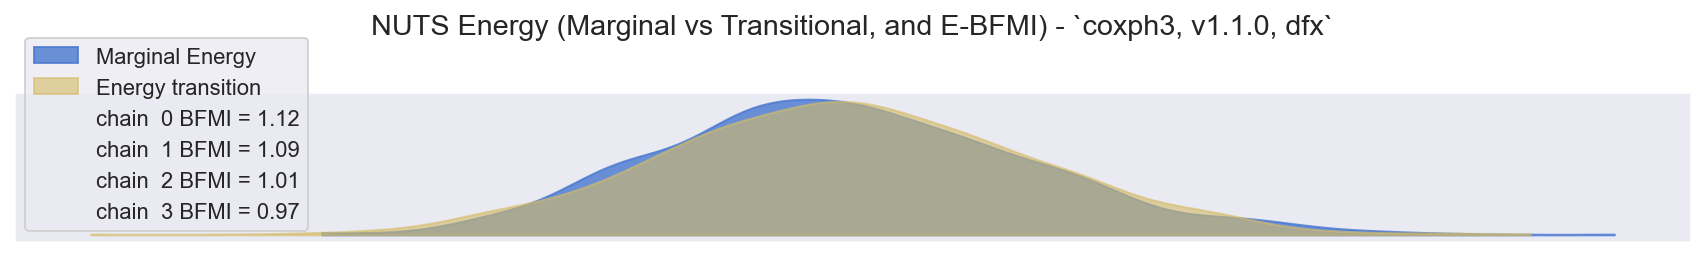

In [17]:
f = mt.plot_trace(mdl=mdl_cox3, rvs=mdl_cox3.rvs_lam + mdl_cox3.rvs_b)
f = mt.plot_energy(mdl=mdl_cox3)
smry = mt.get_summary(mdl=mdl_cox3, rvs=mdl_cox3.rvs_lam + mdl_cox3.rvs_b)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central, although some divergences
+ Most samples well-mixed and well-behaved (`ess_bulk` is good, `r_hat` is good), except for `lambda_j_mu_offset` where 
  `ess_bulk` starting to look a little low and `r_hat` creeping upwards to `1.0.1`
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample) via ECDF

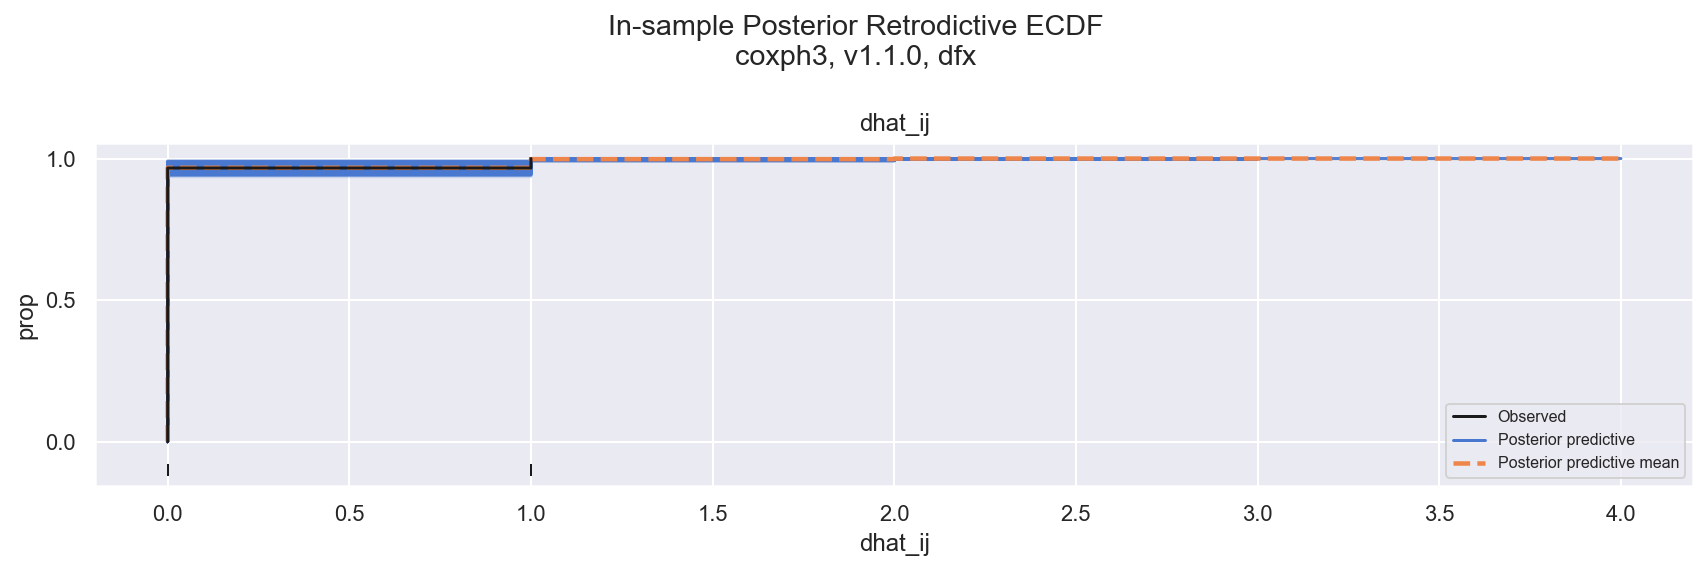

In [18]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdl_cox3, group=GRP, var_names=['dhat_ij'], insamp=True)

**Observe:**

+ This is a pretty nice fit, tight around the real observations $d \in \{0, 1\}$
+ There's still (inevitably) non-zero PPC mass at $d \gt 1$, which is not valid given the problem-space definition (can't die more than 1x in an interval!)

## 2.5 Evaluate via LOO-PIT plots (In-Sample)

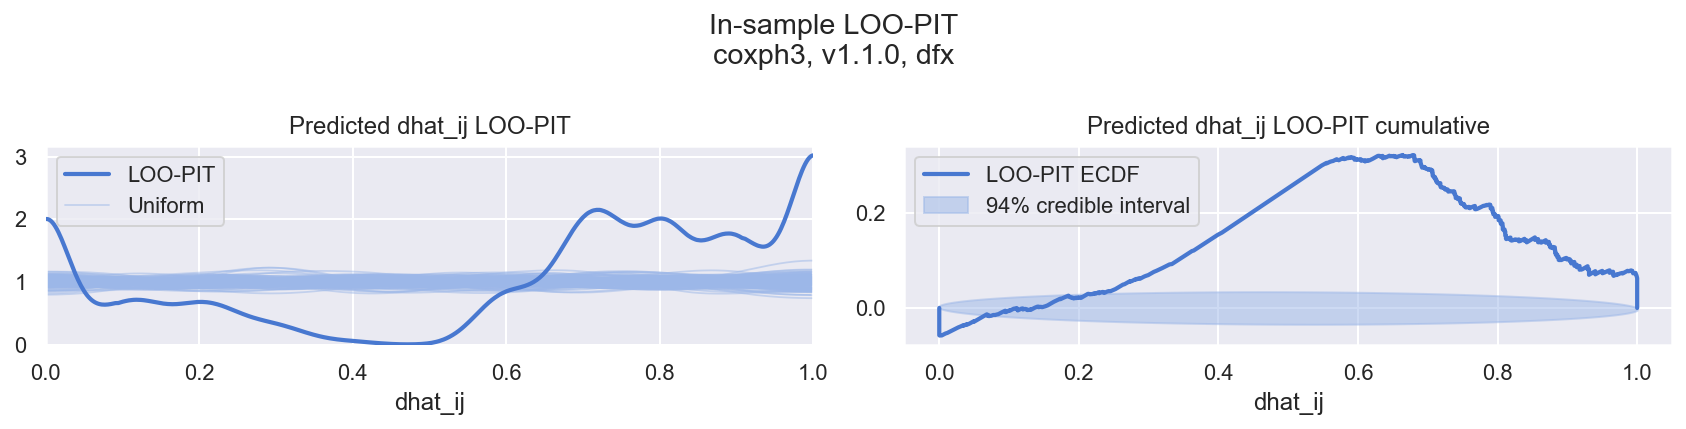

In [19]:
f = mt.plot_loo_pit(mdl_cox3, data_pairs={'dhat_ij': 'dhat_ij'})

**Observe**

+ This LOO-PIT report indicates a slightly poor fit, with underdispersion and bias
+ This isn't a surprise given that the Poisson likelihood has mass at d > 1, and in order to minimize that, has probably placed too much mass on 0.

## 2.6 Compare Log-Likelihood vs other models

### 2.6.1 Reinstantiate earlier models for comparison

In [20]:
mdl_cox0 = exponential.CoxPH0(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox0.build()
mdl_cox0_idata = mdlio.read_idata(mdl=mdl_cox0)
mdl_cox0.update_idata(idata=mdl_cox0_idata)

In [21]:
mdl_cox1 = piecewise.CoxPH1(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox1.build()
mdl_cox1_idata = mdlio.read_idata(mdl=mdl_cox1)
mdl_cox1.update_idata(idata=mdl_cox1_idata)

In [22]:
mdl_cox2 = piecewise.CoxPH1(obs=dfx, fts_en=dfx_creator.fts_en, 
                factor_map=dfx_creator.factor_map, bin_width=STEP, obs_nm='dfx')
mdl_cox2.build()
mdl_cox2_idata = mdlio.read_idata(mdl=mdl_cox2)
mdl_cox2.update_idata(idata=mdl_cox2_idata)

### 2.6.2 Compare

/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jon/miniforge/envs/oreum_survival/lib/python3.11/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jon/miniforge/envs/

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
mdl_cox0\ncoxph0_v120_dfx,0,-111.209552,6.318815,0.000000,1.000000e+00,16.524149,0.000000,True,log
mdl_cox1\ncoxph1_v110_dfx,1,-112.107016,8.231668,0.897464,0.000000e+00,16.990134,0.711247,True,log
mdl_cox2\ncoxph1_v110_dfx,2,-112.107016,8.231668,0.897464,0.000000e+00,16.990134,0.711247,True,log
mdl_cox3\ncoxph3_v110_dfx,3,-114.492023,10.889520,3.282472,8.881784e-16,17.768324,2.089514,True,log


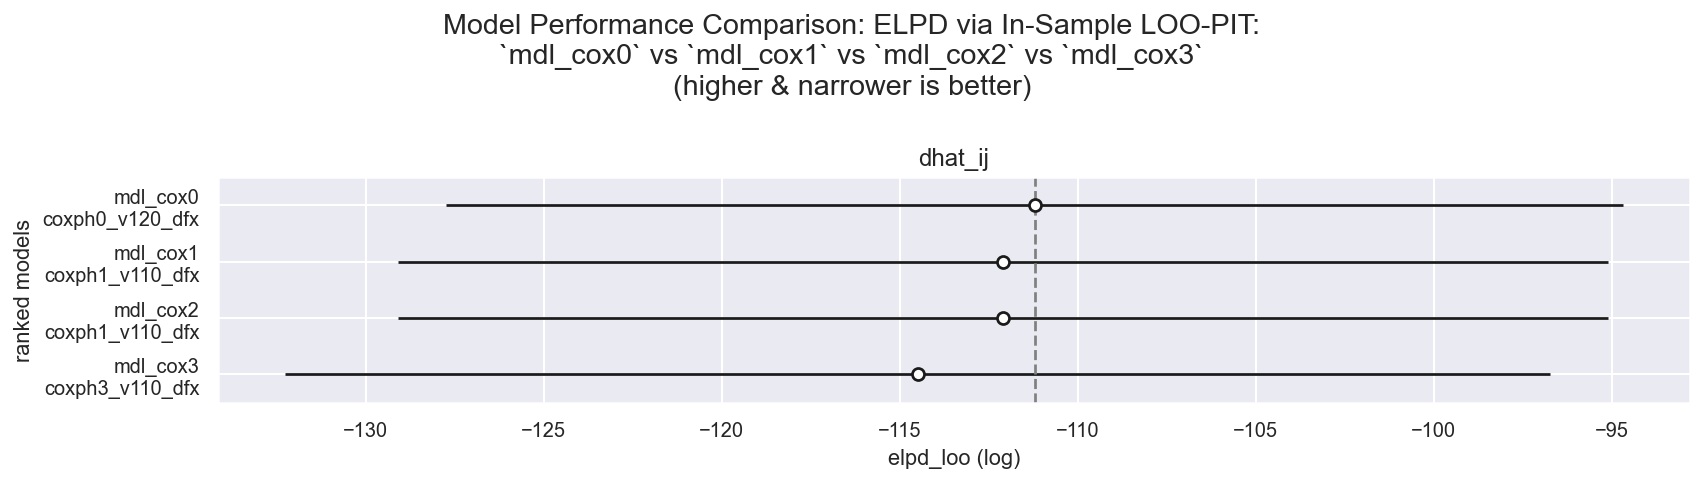

In [23]:
mdl_dict = {'mdl_cox0': mdl_cox0, 'mdl_cox1': mdl_cox1, 'mdl_cox2': mdl_cox2, 'mdl_cox3': mdl_cox3}
f, dcomp = mt.plot_compare(mdl_dict, yhats=['dhat_ij'])
_ = [display(d) for d in dcomp.values()]

**Observe:**

+ Still no improvement on this particular dataset: it's most likely that the additional degrees of freedom (dynamic beta)
  simply result in overfitting on this small dataset
+ The original unpooled `CoxPH0` seems to score best under ELPD, although only slightly, and with substantial overlap

In [24]:
del mdl_cox0, mdl_cox1, mdl_cox2

## 2.7 Evaluate Posterior Parameters

#### Hyperpriors on hazard function

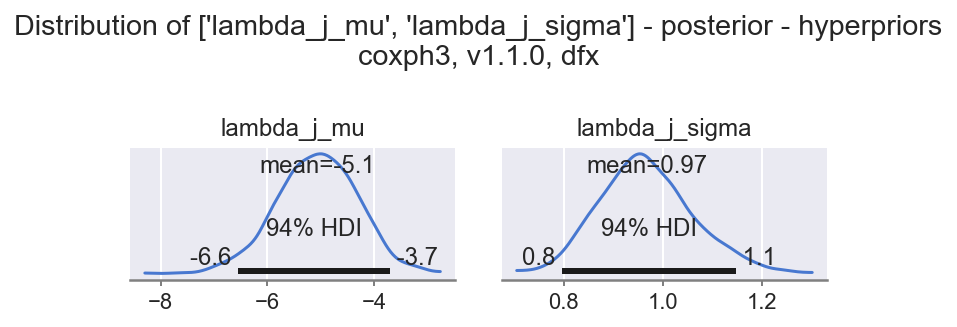

In [25]:
f = mt.facetplot_krushke(mdl=mdl_cox3, group=GRP, txtadd='hyperpriors', rvs=['lambda_j_mu', 'lambda_j_sigma'], m=2)

**Observe:**

+ `lambda_j_mu`: $\mathbb{E} \sim -5.1$, $\text{HDI}_{94}$ narrower than prior, baseline hazard `E(lj) ~ exp(-5) ~ 0.007`
+ `lambda_j_sigma`: $\mathbb{E} \sim 0.97$, $\text{HDI}_{94}$ narrower than prior

#### Baseline hazard function $\lambda_{0}$

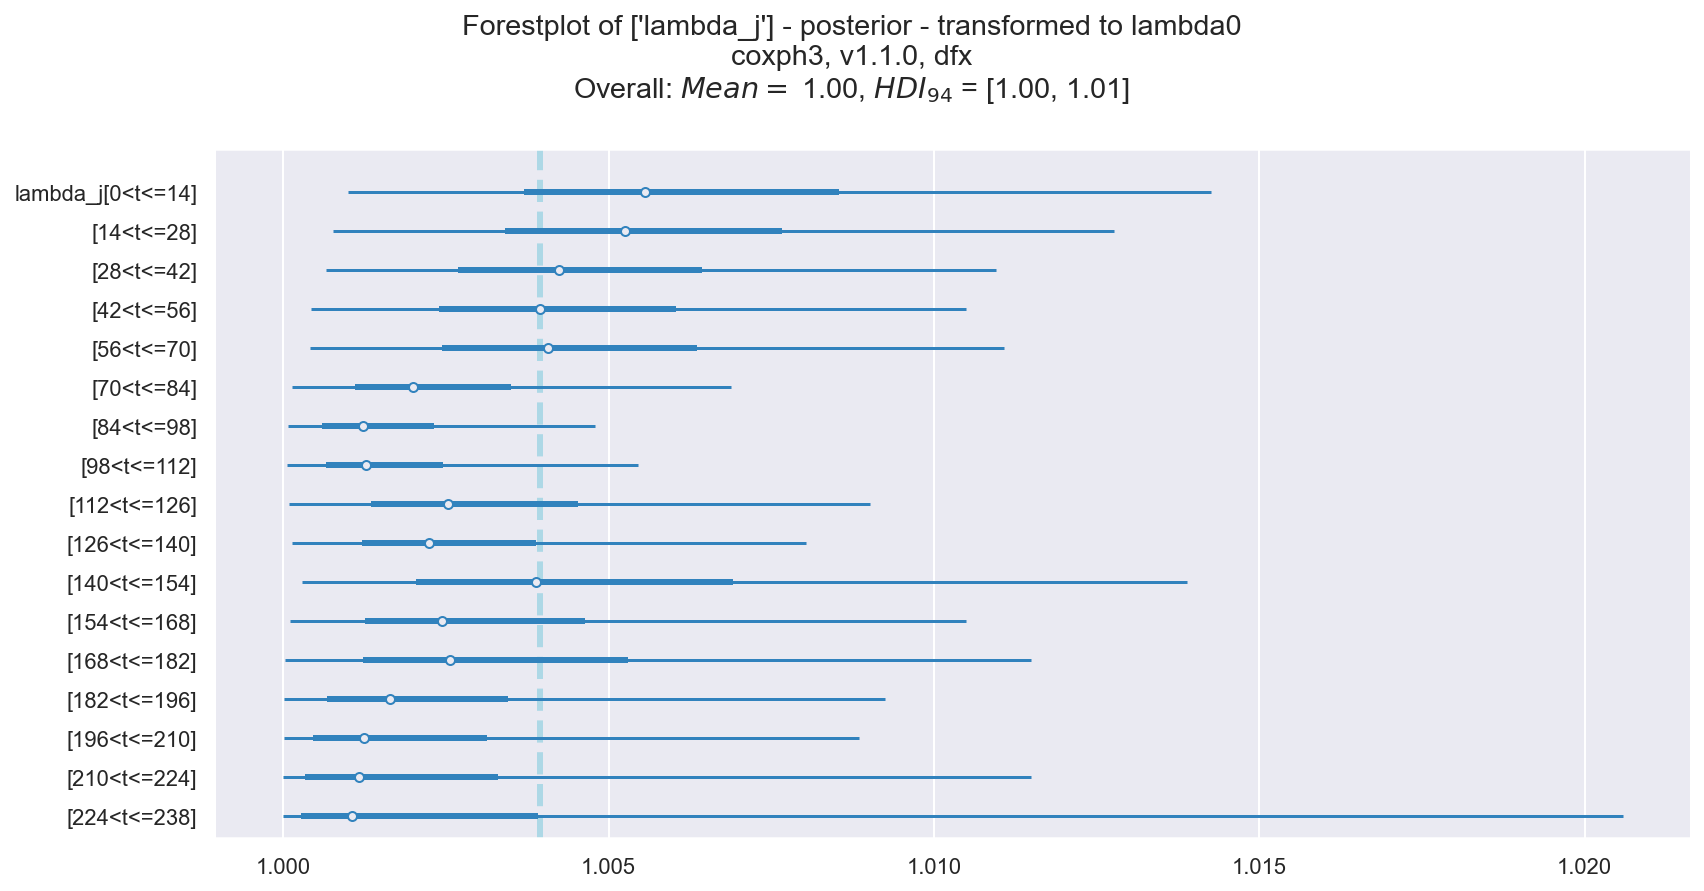

In [26]:
f = mt.forestplot_single(mdl=mdl_cox3, var_names=['lambda_j'], group=GRP, combined=True,
                transform=np.exp, txtadd='transformed to lambda0')

**Observe:**

+ Posteriors look reasonable and we see the effect of allowing $\lambda_{0}$ to vary across time interval
+ Similar to in `CoxPH2` (which is expected, because this part of the architecture is the same) albeit with much 
  wider variance

#### Hyperpriors on $\beta$

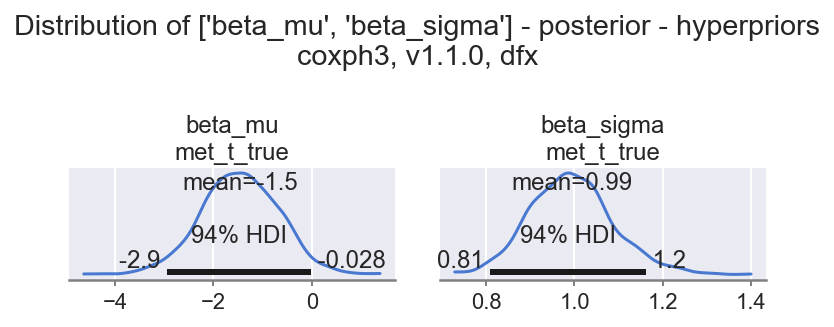

In [27]:
f = mt.facetplot_krushke(mdl=mdl_cox3, group=GRP, txtadd='hyperpriors', rvs=['beta_mu', 'beta_sigma'], m=2)

**Observe**

+ We've set `beta_mu` low to achieve `E(lj) ~ exp(-3) = 0.05`
+ We've set `beta_sigma` to `1` but may need to tighten this up

#### Priors on $\beta$

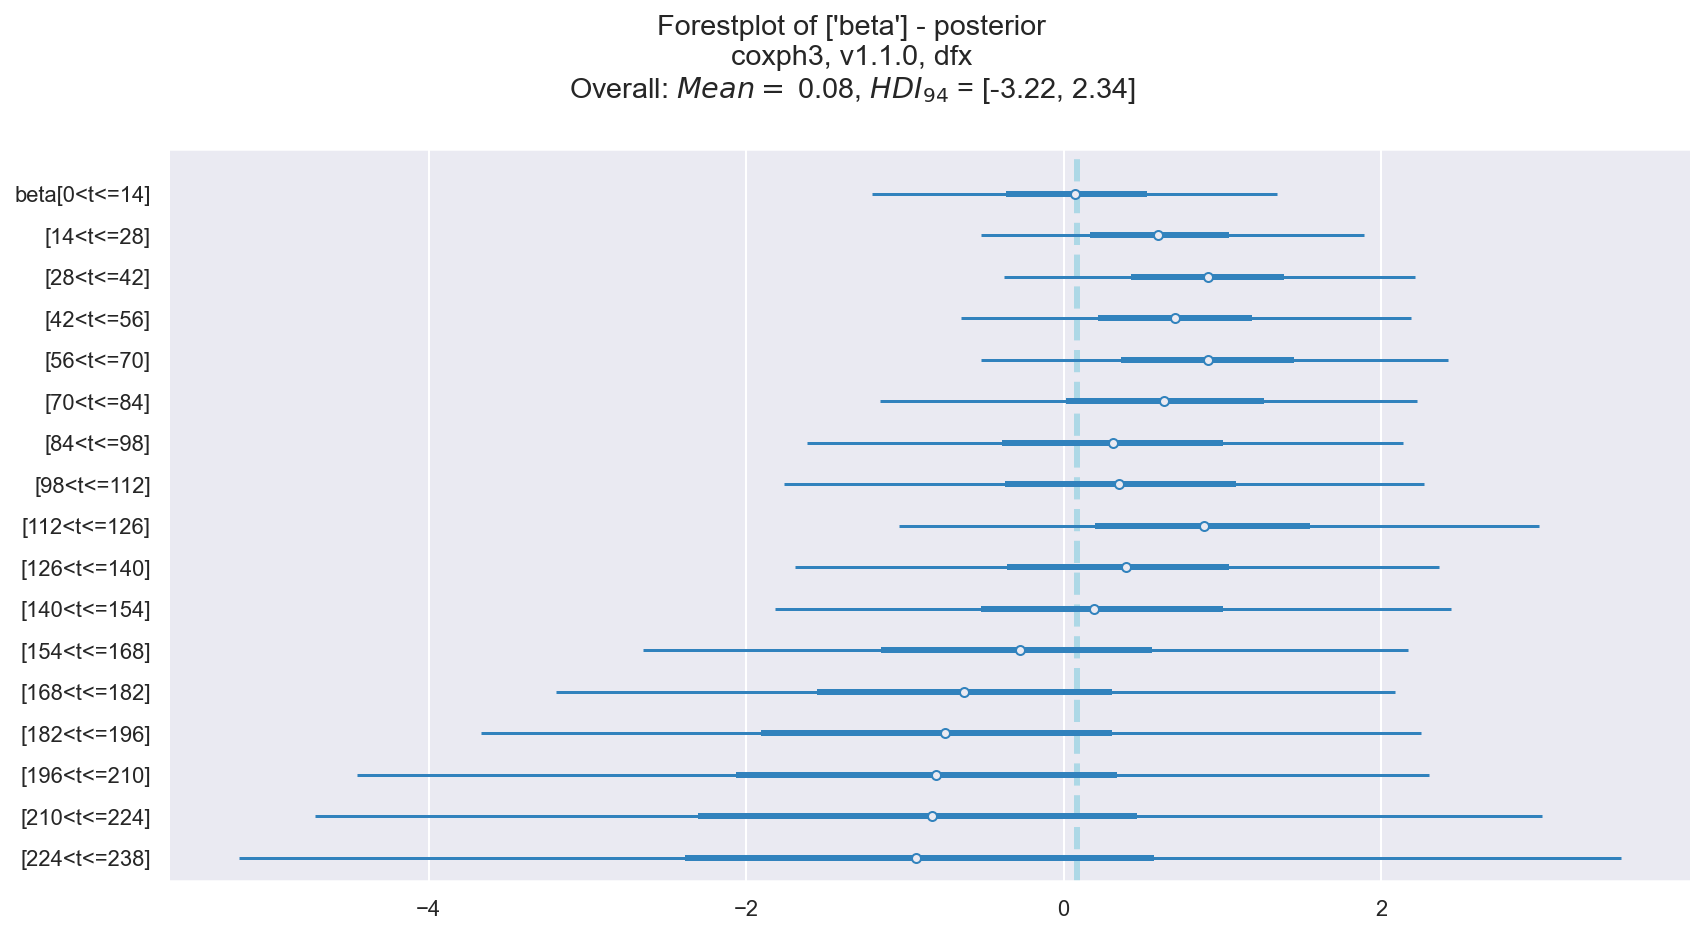

In [28]:
f = mt.forestplot_single(mdl=mdl_cox3, var_names=['beta'], group=GRP)

**Observe:**

+ Posteriors look reasonable and we see the effect of allowing $\beta$ to vary across time interval
+ We see a modal trend whereby $\beta$ grows to a peak in early periods before dropping substantially toward later periods, 
  so `met=True` has a greater effect in the 2 - 3 months post start of observation
+ This pattern is quite interesting! Despite the slightly lower model performance, this inference could be very useful
  in a real-world analysis scenario
+ The `HDI94` also broadens substantially in the later periods as less datapoints have been observed there 

## 2.8 Forecast Survival $\hat{S}(t)$ and Expected Time-to-Event $\hat{\mathbb{E}}_{t}$

Because this model is semi-parametric, we can **forecast** Survival $\hat{S}(j)$ for observations in an **out-of-sample dataset**

However, unlike the fully parametric models:
+ We don't get Expected Time-to-Event "for free" out of the model, because it doesnt have the concept of $\hat{\mathbb{E}}_{t} \sim S^{-1}(u)$
+ Instead, we have to interpolate $\hat{\mathbb{E}}_{t} \sim \int_{0}^{t_{max}} dt \ S(t)$

> See the full detailled discussion in `100_Exponential_Univariate.ipynb` $\S3.8$

### 2.8.1 Create synthetic dataset, calc PPC and extract PPC components

In [29]:
dfs = utils.get_synthetic_df_oos(df, is_coxph=True)
dfsx = dfx_creator.get_dfx(dfs, in_sample=False)

mdl_cox3.replace_obs(obsd={'obs': dfsx}, obs_nm='dfsx')
mdl_cox3.build()
f_idata = mdl_cox3.sample_posterior_predictive(store_ppc=False, ppc_insample=True, var_names=mdl_cox3.rvs_ppc)
dfhat = utils.get_ppc_components_as_dfm(f_idata, getx=True, is_coxph=True, j_nm=mdl_cox3.coords['j_nm'])
dfp = pd.merge(dfhat, dfs.reset_index(), how='left', left_on='oid', right_on='pid')
eda.display_ht(dfp)

Output()

,oid,j_nm,chain,draw,shat_ij,dhat_ij,oid_sub,t_ij,t,tau_min,tau_max,met_t_true,pid,met,death,duration
0,z000,0<t<=14,0,0,0.95,0,z000,14,14,0,14,0,z000,False,False,225
1,z000,0<t<=14,0,1,0.88,0,z000,14,14,0,14,0,z000,False,False,225
2,z000,0<t<=14,0,2,0.88,0,z000,14,14,0,14,0,z000,False,False,225
67997,z001,224<t<=238,3,497,0.28,0,z001,1,225,224,238,1,z001,True,False,225
67998,z001,224<t<=238,3,498,0.21,0,z001,1,225,224,238,1,z001,True,False,225
67999,z001,224<t<=238,3,499,0.32,0,z001,1,225,224,238,1,z001,True,False,225


'Shape: (68000, 16), Memsize 8.7 MB'

### 2.8.2 Plot estimated Survival $\hat{S}(j)$ at intervals $j$ and $\hat{S}(t)$ as interpolated smooth $t$

NOTE:

+ The CoxPH model operates on ordinal intervals $j$, so we must distinguish between predictions $\hat{S}(j)$ vs $\hat{S}(t)$
+ We plot $\hat{S}(j)$ as ordinal points and make no attempt to interpolate time
+ We plot $\hat{S}(t)$ as lines with linearly interpolated time

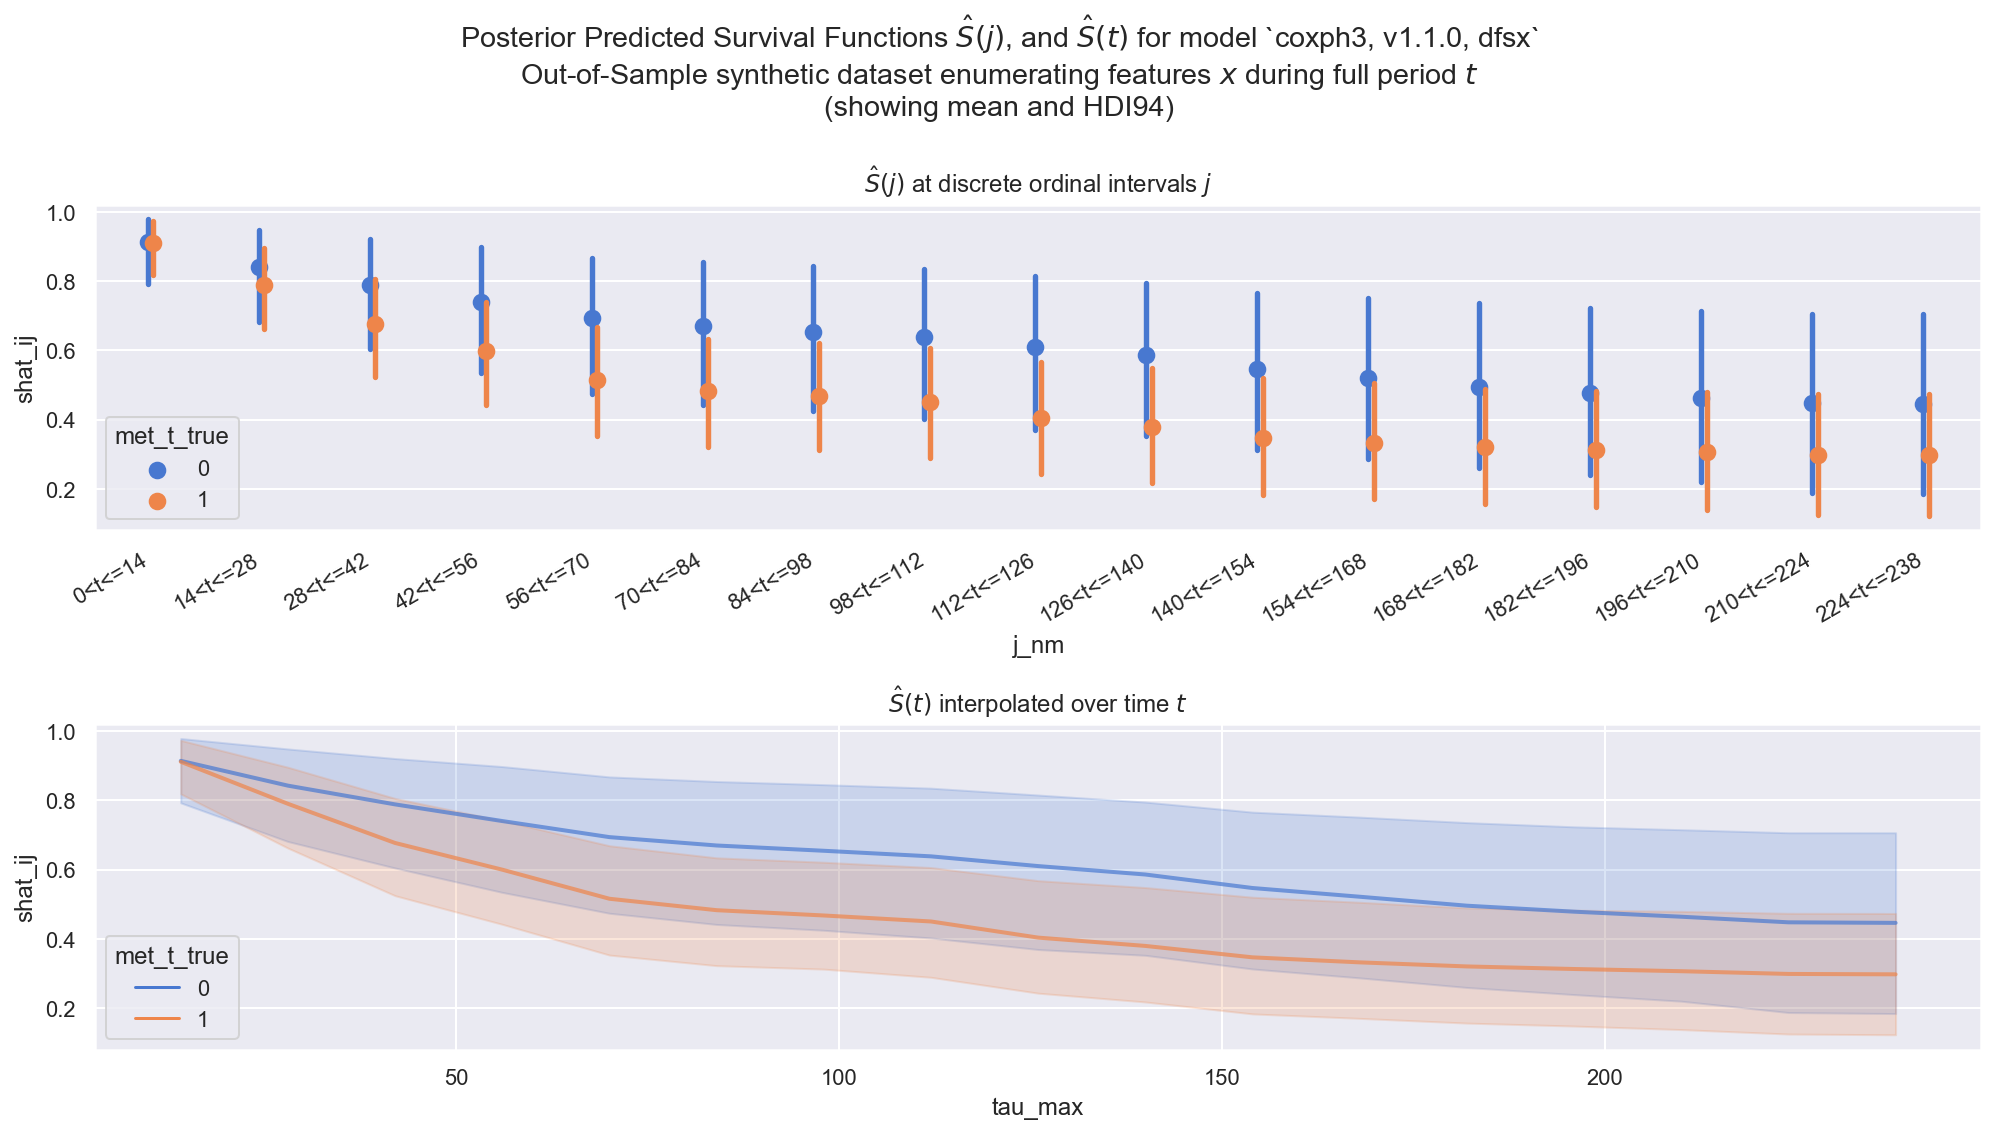

In [30]:
f, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=False)
ax0 = sns.pointplot(x='j_nm', y='shat_ij', hue='met_t_true', data=dfp, join=False, dodge=True, ax=axs[0], 
                    estimator='mean', errorbar=('pi', 94))
_ = ax0.set_xticklabels(ax0.get_xticklabels(), rotation=30, ha='right')
_ = ax0.set_title('$\hat{{S}}(j)$ at discrete ordinal intervals $j$')
ax1 = sns.lineplot(x='tau_max', y='shat_ij', hue='met_t_true', data=dfp, style='met_t_true', ms=10, dashes=False, alpha=0.7, 
                legend=True, lw=2, ax=axs[1], estimator='mean', errorbar=('pi', 94), err_style='band')
_ = ax1.set_title('$\hat{{S}}(t)$ interpolated over time $t$')
_ = f.suptitle(f'Posterior Predicted Survival Functions $\hat{{S}}(j)$, and $\hat{{S}}(t)$ for model `{mdl_cox3.mdl_id}`'
    + '\nOut-of-Sample synthetic dataset enumerating features $x$ during full period $t$'
    + '\n(showing mean and HDI94)')
_ = f.tight_layout()
fqn = figio.write(f, fn=f'302_{mdl_cox3.mdl_id}_forecast_shat')

**Observe:**

+ Even though we saw a very distinguishing value for $\hat{\lambda(t | met=True)}$,
  the combination with $\hat{\lambda_{0}}(t)$ leads to posterior predictions of $\hat{S}(t)$ that have substantial
  overlap between groups `met`
+ In contrast to `CoxPH1` the greater constraint on $\hat{\lambda_{0}}(t)$ means slightly more explanatory power lands on `\beta`

### 2.8.3 Expected time-to-event $\hat{\mathbb{E}}_{t}$

We integrate the curve $\hat{S}(t)$ assuming linearly interpolated time

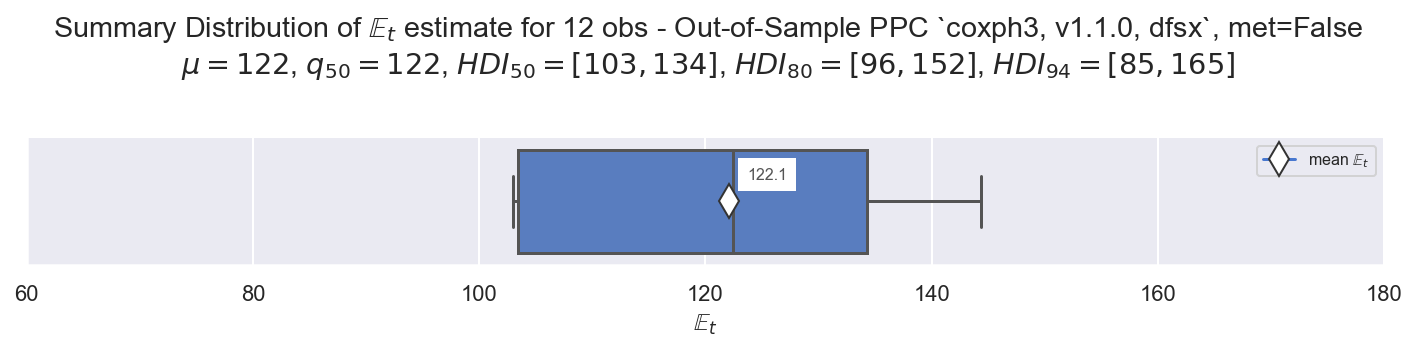

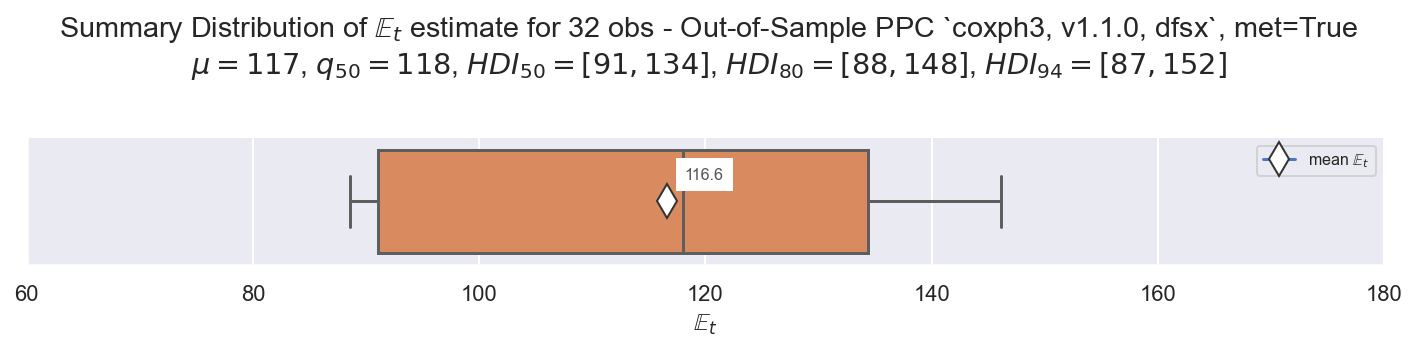

In [31]:
df_et = dfp.groupby(['oid_sub', 'chain', 'draw', 'met_t_true'])\
            .apply(lambda g: np.trapz(y=g['shat_ij'], x=g['tau_max']), include_groups=False)\
            .to_frame('$\mathbb{E}_{t}$')
            
f = eda.plot_estimate(df=df_et.loc[:, :, 0], nobs=len(dfx) - dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox3.mdl_id}`, met=False',force_xlim=(60, 180))
fqn = figio.write(f, fn=f'302_{mdl_cox3.mdl_id}_forecast_et_met_false')

f = eda.plot_estimate(df=df_et.loc[:, :, 1],nobs=dfx['met_t_true'].sum(), yhat='$\mathbb{E}_{t}$',
    txtadd=f'Out-of-Sample PPC `{mdl_cox3.mdl_id}`, met=True', color='C1', force_xlim=(60, 180))
fqn = figio.write(f, fn=f'302_{mdl_cox3.mdl_id}_forecast_et_met_true')

**Observe:**

+ Now here's the distribution of forecasted expected survival times $\mathbb{E}_{t}$ for our **synthetic out-of-sample dataset**
  + For `met = False`: $\mathbb{E}_{t} \sim 122 \in [85, 165]_{HDI94}$ days
  + For `met = True`: $\mathbb{E}_{t} \sim 117 \in [87, 152]_{HDI94}$ days
+ These empirical predicted distributions have substantial degree of overlap
+ These are very similar to `CoxPH2`, `CoxPH1` and `CoxPH0`, although the means are more central (closer to the median)
  which is intersting and in a real-world scenario would be worthy of further investigation

# Notes

In [32]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

Author: jonathan.sedar@oreum.io

Last updated: 2024-11-18 18:04:30

Python implementation: CPython
Python version       : 3.11.10
IPython version      : 8.29.0

pymc    : 5.16.2
pytensor: 2.25.5

Compiler    : Clang 17.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

oreum_core: 0.9.7
seaborn   : 0.12.2
pyprojroot: 0.3.0
pandas    : 2.2.3
matplotlib: 3.9.2
sys       : 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
numpy     : 1.26.4



---
**Oreum OÜ &copy; 2024**